# Example of the ml_regressor() function 

Author: Charles Le Losq

**`rampy.mlregressor` performs automatic data scaling, hyperparameter grid search and provides access to popular algorithms (Support Vector, Kernel Rdige, Neural Nets) for using machine learning in a regression task implying spectroscopic data.** This function allows one to link any variable to a set of spectra with using a machine learning technique. 

Let's assume for the sack of example that we observe spectra D that are the combination of $k$ endmember spectra S with concentrations C, such that:

$$ D_{i,j} = C_{i,k} \times S_{k,j} $$

Here we assume a linear combination. In Python, assuming that the partial spectra are simple Gaussians, we can write the following.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import rampy as rp
from scipy.stats import norm

In [2]:
x = np.arange(0,600,1.0)

S_1 = norm.pdf(x,loc=200.,scale=130.)
S_2 = norm.pdf(x,loc=400,scale=70)
S_true = np.vstack((S_1,S_2))
print("Shape of partial spectra matrix:"+str(S_true.shape))

C_ = np.random.rand(40) #40 samples with random concentrations between 0 and 1
C_true = np.vstack((C_,(1-C_))).T
print("Shape of concentration matrix:"+str(C_true.shape))


Shape of partial spectra matrix:(2, 600)
Shape of concentration matrix:(40, 2)


We make some observations with random noise

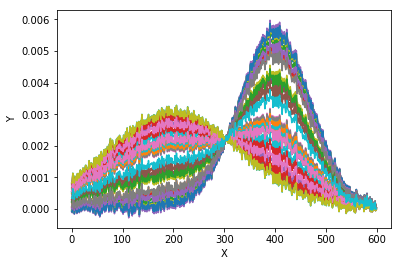

In [3]:
noise = np.random.randn(len(x))*1e-4
Obs = np.dot(C_true,S_true) + noise

plt.plot(x,Obs.T)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Machine Learning

We can train a machine learning algorithm to follow changes in D as a function of C, assuming we measured both quantities.

Rampy uses scikit_learn algorithms to do so in a easy way, with under-the-hood standardization and cross-validation. This is to use for "simple" projects, while more complicated things will required an ad hoc approach, directly using scikit-learn or any other relevant ML library.

For now, we will show how we can train neural networks to link D and C, such that we can predict C from new observations of D.

Let's first print the help to read the documentation...

In [4]:
help(rp.mlregressor)

Help on function mlregressor in module rampy.ml_regressor:

mlregressor(x, y, algorithm='SVM', **kwargs)
    use machine learning algorithms from scikit learn to perform regression between spectra and an observed variable.
    
    Parameters
    x : array{Float64}
            the spectra organised in rows (1 row = one spectrum). The spectra should share a common X axis.
    y : Array{Float64}
            Target. Only a single target is possible for now.
    algorithm : String,
            "KernelRidge", "SVM", "LinearRegression", "Lasso", "ElasticNet", "NeuralNet", "BaggingNeuralNet", default = "SVM"
    
    Returns
    prediction_train : Array{Float64}
            the predicted target values for the training y dataset.
    prediction_test : Array{Float64}
            the predicted target values for the testing y_test dataset.
    model : Scikit learn model
            A Scikit Learn object model, see scikit learn library documentation.
    X_scaler :
            A Scikit Learn scale

# Choice of the algorithm

Many popular algorithms are possible: [KernelRidge](http://scikit-learn.org/stable/modules/kernel_ridge.html),  [SVM](http://scikit-learn.org/stable/modules/kernel_ridge.html), [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), [NeuralNet](http://scikit-learn.org/stable/modules/neural_networks_supervised.html), [BaggingNeuralNet](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor).

LinearRegression, Lasso and ElasticNet are borned to linear problems, while KernelRidge, SVM, NeuralNet or BaggingNeuralNet can do both linear and non-linear problems. See the documentation of scikit-learn for further details, and all the articles online on those techniques. Those techniques need hyperparameters that are provided as a dictionary to `rampy.mlregressor`. I strongly encourage you to read the documentation on scikit-learn for the technique you want to use, in order to set those hyperparameters in the good range.

In the present case, we are dealing with a linear problem. We thus can use the [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) algorithms.

Machine learning algorithms need a training dataset, and their performance is evaluated on a "testing" dataset that is unseen of the algorithm. `rp.mlregressor` can split your dataset automatically, or you can choose to provide the two different datasets. Parameters for each algorithm are provided as a dictionary, see the documentation of [scikit-learn](http://scikit-learn.org/stable/index.html) for further details on them. The datasets are also standardized/normalised inside the function (if you don't know what this means, click [here](http://scikit-learn.org/stable/modules/preprocessing.html)). The type of scaling is changed by the `scaler` option.

`rp.mlregressor` outputs five things: 

- prediction_train: the predicted target values for the training y dataset.
- prediction_test: the predicted target values for the testing y_test dataset.
- model: A Scikit Learn object model, see scikit learn library documentation.
- X_scaler: A Scikit Learn scaler object for the x values.
- Y_scaler: A Scikit Learn scaler object for the y values.

including the predicted values of the training and testing datasets, the model in itself (an scikit-learn object), as well as the scalers. Indeed, data need to be scaled prior to applying the algorithm, and new data can be scaled with the existing scaler as we will see below.

For now, let's train our lasso algorithm. This is one line of code:

In [34]:
import sklearn
from sklearn import model_selection
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import BaggingRegressor
class mlregressor:
    """use machine learning algorithms from scikit learn to perform regression between spectra and an observed variable.

    
    Attributes
    ----------
    x : {array-like, sparse matrix}, shape = (n_samples, n_features)
        Spectra; n_features = n_frequencies.
    y : array, shape = (n_samples,)
        Returns predicted values.
    X_test : {array-like, sparse matrix}, shape = (n_samples, n_features)
        spectra organised in rows (1 row = one spectrum) that you want to use as a testing dataset. THose spectra should not be present in the x (training) dataset. The spectra should share a common X axis.
    y_test : array, shape = (n_samples,)
        the target that you want to use as a testing dataset. Those targets should not be present in the y (training) dataset.
    algorithm : String,
        "KernelRidge", "SVM", "LinearRegression", "Lasso", "ElasticNet", "NeuralNet", "BaggingNeuralNet", default = "SVM"
    scaler : String
        the type of scaling performed. Choose between MinMaxScaler or StandardScaler, see http://scikit-learn.org/stable/modules/preprocessing.html for details. Default = "MinMaxScaler".
    test_size : float
        the fraction of the dataset to use as a testing dataset; only used if X_test and y_test are not provided.
    rand_state : Float64
        the random seed that is used for reproductibility of the results. Default = 42.
    user_kernel : String
        the kernel to be used by SVM or KernelRidge.
    param_grid_kr : Dictionary
        contain the values of the hyperparameters that should be checked by gridsearch for the Kernel Ridge regression algorithm.
    param_grid_svm : Dictionary
        containg the values of the hyperparameters that should be checked by gridsearch for the Support Vector regression algorithm.
    param_neurons : Dictionary
        contains the options for the Neural Network. Default= dict(layers=(3,),solver = 'lbfgs',funct='relu',early_stopping=True)
    param_bagging : Dictionary
        contains the options for the BaggingNeuralNet method used with neural nets. Default= dict(n_estimators=100, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=rand_state, verbose=0)
    
    prediction_train : Array{Float64}
        the predicted target values for the training y dataset.
    prediction_test : Array{Float64}
        the predicted target values for the testing y_test dataset.
    model : Scikit learn model
        A Scikit Learn object model, see scikit learn library documentation.
    X_scaler :
        A Scikit Learn scaler object for the x values.
    Y_scaler :
        A Scikit Learn scaler object for the y values.
    
    Remarks
    -------

    For details on hyperparameters of each algorithms, please directly consult the documentation of SciKit Learn at:

    http://scikit-learn.org/stable/

    For Support Vector and Kernel Ridge regressions, mlregressor performs a cross_validation search with using 5 KFold cross validators.

    If the results are poor with Support Vector and Kernel Ridge regressions, you will have to tune the param_grid_kr or param_grid_svm dictionnary that records the hyperparameter space to investigate during the cross validation.

    Results for machine learning algorithms can vary from run to run. A way to solve that is to fix the random_state. 
    For neural nets, results from multiple neural nets (bagging technique) may also generalise better, such that
    it may be better to use the BaggingNeuralNet function.

    """
 
    def __init__(self,x,y,**kwargs):
        """  
        Parameters
        ----------
        x : array{Float64}
            the spectra organised in rows (1 row = one spectrum). The spectra should share a common X axis.
        y : Array{Float64}
            Target. Only a single target is possible for now.

        """
        self.x = x
        self.y = y
        #
        # Kwargs extractions
        #
        self.X_test = X_test = kwargs.get("X_test",[0.0])
        self.y_test = kwargs.get("y_test",[0.0])
        self.algorithm = kwargs.get("algorithm","SVM")
        self.test_sz = kwargs.get("test_size",0.3)
        self.scaling = kwargs.get("scaling","yes")
        self.scaler = kwargs.get("scaler","MinMaxScaler")
        self.rand_state = kwargs.get("rand_state",42)
        self.param_grid_kr = kwargs.get("param_grid_kr",dict(alpha=[1e1, 1e0, 0.5, 0.1, 5e-2, 1e-2, 5e-3, 1e-3],gamma=np.logspace(-4, 4, 9)))
        self.param_grid_svm= kwargs.get("param_grid_svm",dict(C= [1e0, 2e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5], gamma= np.logspace(-4, 4, 9)))
        self.user_kernel = kwargs.get("user_kernel","rbf")
        self.param_neurons = kwargs.get("param_neurons",dict(layers=(3,),solver = 'lbfgs',funct='relu',early_stopping=True))
        self.param_bag = kwargs.get("param_bagging",dict(n_estimators=100, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, verbose=0))    
        
        if len(self.X_test) == 1:
            self.X_train, self.X_test, self.y_train, self.y_test = sklearn.model_selection.train_test_split(
            self.x, self.y.reshape(-1, 1), test_size=self.test_sz, random_state=self.rand_state)
        elif self.X_test.shape[1] == self.x.shape[1]:
            self.X_train = np.copy(self.x)
            self.y_train = np.copy(self.y)
        else:
            ValueError("You tried to provide a testing dataset that has a different number of features (in columns) than the training set. Please correct this.")

        # to avoid any problem with SciKit Learn quite annoying demands for the shape of arrays...
        self.y_train = self.y_train.reshape(-1,1)
        self.y_test = self.y_test.reshape(-1, 1)

        # initialising the preprocessor scaler
        if self.scaler == "StandardScaler":
            self.X_scaler = sklearn.preprocessing.StandardScaler()
            self.Y_scaler = sklearn.preprocessing.StandardScaler()
        elif self.scaler == "MinMaxScaler":
            self.X_scaler = sklearn.preprocessing.MinMaxScaler()
            self.Y_scaler = sklearn.preprocessing.MinMaxScaler()
        else:
            InputError("Choose the scaler between MinMaxScaler and StandardScaler")

    def fit(self):
        """Train the model with the indicated algorithm.

        Do not forget to tune the hyperparameters.

        Parameters
        ----------
        algorithm : String,
            "KernelRidge", "SVM", "LinearRegression", "Lasso", "ElasticNet", "NeuralNet", "BaggingNeuralNet", default = "SVM"

        """
        self.X_scaler.fit(self.X_train)
        self.Y_scaler.fit(self.y_train)

        # scaling the data
        self.X_train_sc = self.X_scaler.transform(self.X_train)
        self.y_train_sc = self.Y_scaler.transform(self.y_train)

        self.X_test_sc = self.X_scaler.transform(self.X_test)
        self.y_test_sc = self.Y_scaler.transform(self.y_test)

        if self.algorithm == "KernelRidge":
            clf_kr = KernelRidge(kernel=self.user_kernel, gamma=0.1)
            self.model = sklearn.model_selection.GridSearchCV(clf_kr, cv=5, param_grid=self.param_grid_kr)
        
        elif self.algorithm == "SVM":
            clf_svm = SVR(kernel=self.user_kernel, gamma=0.1)
            self.model = sklearn.model_selection.GridSearchCV(clf_svm, cv=5, param_grid=self.param_grid_svm)
        
        elif self.algorithm == "Lasso":
            clf_lasso = sklearn.linear_model.Lasso(alpha=0.1,random_state=self.rand_state)
            self.model = sklearn.model_selection.GridSearchCV(clf_lasso, cv=5,
                                                              param_grid=dict(alpha=[1e-3,1e-2,1e-1,1.,1e1,1e2,1e3,1e4]))
        
        elif self.algorithm == "ElasticNet":
            clf_ElasticNet = sklearn.linear_model.ElasticNet(alpha=0.1, l1_ratio=0.5,random_state=self.rand_state)
            self.model = sklearn.model_selection.GridSearchCV(clf_ElasticNet,cv=5, 
                                                              param_grid=dict(alpha=[1e-3, 1e-2, 1e-1, 1., 1e1, 1e2, 1e3, 1e4]))
        
        elif self.algorithm == "LinearRegression":
            self.model = sklearn.linear_model.LinearRegression()
        
        elif self.algorithm == "NeuralNet":
            self.model = MLPRegressor(hidden_layer_sizes=self.param_neurons['layers'],
                                      activation=self.param_neurons['funct'],
                                      solver=self.param_neurons['solver'],
                                      random_state=self.rand_state)
        elif self.algorithm == "BaggingNeuralNet":
            nn_m = MLPRegressor(hidden_layer_sizes=self.param_neurons['layers'], 
                                 activation=self.param_neurons['funct'],
                                solver=self.param_neurons['solver'],
                                early_stopping=self.param_neurons['early_stopping'])
            
            self.model = BaggingRegressor(base_estimator=nn_m, 
                                          n_estimators=self.param_bag['n_estimators'], 
                                          max_samples=self.param_bag['max_samples'], 
                                          max_features=self.param_bag['max_features'], 
                                          bootstrap=self.param_bag['bootstrap'], 
                                          bootstrap_features=self.param_bag['bootstrap_features'],
                                          oob_score=self.param_bag['oob_score'], 
                                          warm_start=self.param_bag['warm_start'],
                                          n_jobs=self.param_bag['n_jobs'], 
                                          random_state=self.rand_state, 
                                          verbose=self.param_bag['verbose'])

        if self.scaling == "yes":
            self.model.fit(self.X_train_sc, self.y_train_sc.reshape(-1,))
            predict_train_sc = self.model.predict(self.X_train_sc)
            self.prediction_train = self.Y_scaler.inverse_transform(predict_train_sc.reshape(-1,1))
            predict_test_sc = self.model.predict(self.X_test_sc)
            self.prediction_test = self.Y_scaler.inverse_transform(predict_test_sc.reshape(-1,1))
        else:
            self.model.fit(self.X_train, self.y_train.reshape(-1,))
            self.prediction_train = self.model.predict(self.X_train)
            self.prediction_test = self.model.predict(self.X_test)
    
    def predict(self,X):
        """Predict using the model.
        
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = (n_samples, n_features)
            Samples.
        
        Returns
        -------
        C : array, shape = (n_samples,)
            Returns predicted values.
            
        Remark
        ------
        if self.scaling == "yes", scaling will be performed on the input X.
        """
        if self.scaling == "yes":
            X_sc = self.X_scaler.transform(X)
            pred_sc = self.model.predict(X_sc)
            return self.Y_scaler.inverse_transform(pred_sc.reshape(-1,1))
        else:
            return self.model.predict(self.X)

In [35]:
model = mlregressor(Obs,C_true[:,0].reshape(-1,1))

In [36]:
for i in ["KernelRidge", "SVM", "LinearRegression", "Lasso", "ElasticNet", "NeuralNet", "BaggingNeuralNet"]:
    model.algorithm = i
    model.fit()

/home/charles/py36/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/charles/py36/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/charles/py36/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/charles/py36/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

NameError: name 'param_neurons' is not defined

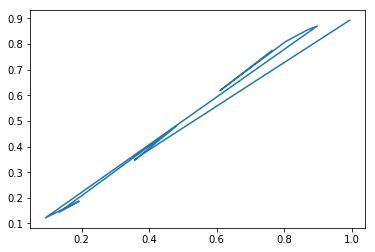

In [32]:
plt.plot(model.y_test,model.prediction_test)